### Регрессия для SI

In [8]:
import numpy as np
import pandas as pd

In [2]:
df_scaled = pd.read_csv('df_scaled.csv')

In [3]:
df_scaled.shape

(969, 188)

In [4]:
df_scaled.head()

,IC50,CC50,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.599333,-0.648886,0.023693,-1.766931,-1.766931,1.230105,0.859969,-0.751719,1.076111,0.260487,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
1,-0.623447,-0.917447,-0.258103,-2.112017,-2.112017,2.098636,0.953566,-0.540135,1.257528,0.292155,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
2,0.360199,-0.671529,-0.341875,-2.518530,-2.518530,2.154087,0.959542,-1.485466,1.017293,0.748665,...,6.379466,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
3,-0.619328,-0.755671,0.492044,-1.765937,-1.765937,1.250111,0.862125,-0.937063,0.991464,0.370656,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,3.080565,-0.085302
4,-0.154375,-0.706065,-0.334138,-1.749744,-1.749744,0.538633,0.785453,-0.696952,0.567012,0.905000,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,-0.169372,-0.085302


### Сравнены различные модели с настройкой гиперпараметров, сделаны выводы о применимости методов, даны рекомендации по улучшению.

In [5]:
import joblib
import matplotlib.pyplot as plt
import optuna
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

# Загрузка данных

y = df_scaled['SI']  # Целевая переменная
X = df_scaled.drop(columns=['SI', 'CC50', 'IC50'])  # Признаки

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Словарь регрессоров для оптимизации
REGRESSORS = {
    'XGBRegressor': XGBRegressor,
    'DecisionTreeRegressor': DecisionTreeRegressor,
    'RandomForestRegressor': RandomForestRegressor,
    'CatBoostRegressor': CatBoostRegressor
}

def objective(trial, regressor_name):
    """Оптимизация гиперпараметров."""
    if regressor_name == 'XGBRegressor':
        params = {
            'objective': 'reg:squarederror',
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = XGBRegressor(**params)
        
    elif regressor_name == 'DecisionTreeRegressor':
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = DecisionTreeRegressor(**params)

    elif regressor_name == 'RandomForestRegressor':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = RandomForestRegressor(**params)

    elif regressor_name == 'CatBoostRegressor':
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'depth': trial.suggest_int('depth', 1, 10),
            'iterations': trial.suggest_int('iterations', 50, 550),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
            'verbose': 0  
        }
        model = CatBoostRegressor(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Используем только MSE для оптимизации
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Оптимизация гиперпараметров для каждого регрессора
best_models = {}
for regressor_name in REGRESSORS.keys():
    print(f"Оптимизация гиперпараметров для {regressor_name}...")
    study = optuna.create_study(direction='minimize')  # Минимизируем только MSE
    study.optimize(lambda trial: objective(trial, regressor_name), n_trials=250)

    # Получаем наилучшие параметры и модель
    best_trial = study.best_trial
    best_model = REGRESSORS[regressor_name](**best_trial.params).fit(X_train, y_train)
    best_models[regressor_name] = {
        'best_params': best_trial.params,
        'best_model': best_model,
    }

    print(f"Оптимальные гиперпараметры для {regressor_name}:", best_trial.params)

# Оценка всех моделей на тестовой выборке
for regressor_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print(f"{regressor_name} - Тестовый MSE: {mse}, Тестовый MAE: {mae}, Тестовый R^2: {r2}")


[I 2025-05-24 10:05:56,332] A new study created in memory with name: no-name-ff03be0f-dbdc-456f-ac81-fa1510119302


Оптимизация гиперпараметров для XGBRegressor...


[I 2025-05-24 10:05:56,783] Trial 0 finished with value: 1.2407620262558559 and parameters: {'learning_rate': 0.0003668150827943792, 'max_depth': 8, 'n_estimators': 90, 'subsample': 0.8250816376978949, 'colsample_bytree': 0.8222548020692028}. Best is trial 0 with value: 1.2407620262558559.
[I 2025-05-24 10:05:59,028] Trial 1 finished with value: 1.162725868399791 and parameters: {'learning_rate': 0.015374201490093175, 'max_depth': 13, 'n_estimators': 249, 'subsample': 0.8372250947651406, 'colsample_bytree': 0.6037418381824233}. Best is trial 1 with value: 1.162725868399791.
[I 2025-05-24 10:06:01,687] Trial 2 finished with value: 1.1390205442100427 and parameters: {'learning_rate': 0.007132528248589694, 'max_depth': 14, 'n_estimators': 284, 'subsample': 0.7119372488008071, 'colsample_bytree': 0.6969062419672469}. Best is trial 2 with value: 1.1390205442100427.
[I 2025-05-24 10:06:02,540] Trial 3 finished with value: 1.2445126462649678 and parameters: {'learning_rate': 0.000328988678643

Оптимальные гиперпараметры для XGBRegressor: {'learning_rate': 0.013364300195712787, 'max_depth': 5, 'n_estimators': 178, 'subsample': 0.9804098696360458, 'colsample_bytree': 0.5199817939000623}
Оптимизация гиперпараметров для DecisionTreeRegressor...


[I 2025-05-24 10:08:13,525] Trial 5 finished with value: 1.2561842143791 and parameters: {'max_depth': 1, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 5 with value: 1.2561842143791.
[I 2025-05-24 10:08:13,557] Trial 6 finished with value: 1.3084343919673025 and parameters: {'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 5 with value: 1.2561842143791.
[I 2025-05-24 10:08:13,590] Trial 7 finished with value: 1.3428719778237561 and parameters: {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 5 with value: 1.2561842143791.
[I 2025-05-24 10:08:13,598] Trial 8 finished with value: 1.1373017871128346 and parameters: {'max_depth': 1, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 8 with value: 1.1373017871128346.
[I 2025-05-24 10:08:13,603] Trial 9 finished with value: 1.1839907900438704 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 8 with value: 1.137

Оптимальные гиперпараметры для DecisionTreeRegressor: {'max_depth': 1, 'min_samples_split': 3, 'min_samples_leaf': 10}
Оптимизация гиперпараметров для RandomForestRegressor...


[I 2025-05-24 10:08:18,793] Trial 0 finished with value: 1.205374464982751 and parameters: {'n_estimators': 143, 'max_depth': 1, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 1.205374464982751.
[I 2025-05-24 10:08:19,415] Trial 1 finished with value: 1.0797404342106218 and parameters: {'n_estimators': 67, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 1.0797404342106218.
[I 2025-05-24 10:08:20,740] Trial 2 finished with value: 1.1825096619510913 and parameters: {'n_estimators': 461, 'max_depth': 1, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 1.0797404342106218.
[I 2025-05-24 10:08:28,613] Trial 3 finished with value: 1.0509836168190843 and parameters: {'n_estimators': 467, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 3 with value: 1.0509836168190843.
[I 2025-05-24 10:08:29,916] Trial 4 finished with value: 1.055623502748701 and parameters: {'n_e

Оптимальные гиперпараметры для RandomForestRegressor: {'n_estimators': 64, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 5}
Оптимизация гиперпараметров для CatBoostRegressor...


[I 2025-05-24 10:20:00,182] Trial 0 finished with value: 1.2315974275695067 and parameters: {'learning_rate': 0.003334084813382082, 'depth': 5, 'iterations': 128, 'l2_leaf_reg': 1.0048972031695615}. Best is trial 0 with value: 1.2315974275695067.
[I 2025-05-24 10:20:00,327] Trial 1 finished with value: 1.2542209098396022 and parameters: {'learning_rate': 0.0031042848137268473, 'depth': 1, 'iterations': 79, 'l2_leaf_reg': 0.005617002785647439}. Best is trial 0 with value: 1.2315974275695067.
[I 2025-05-24 10:20:01,076] Trial 2 finished with value: 1.1164213983281221 and parameters: {'learning_rate': 0.04275008633858751, 'depth': 4, 'iterations': 423, 'l2_leaf_reg': 0.21199506824029102}. Best is trial 2 with value: 1.1164213983281221.
[I 2025-05-24 10:20:29,266] Trial 3 finished with value: 1.2499054211462715 and parameters: {'learning_rate': 0.00013360017782382041, 'depth': 10, 'iterations': 313, 'l2_leaf_reg': 6.379442659321666}. Best is trial 2 with value: 1.1164213983281221.
[I 2025-

0:	learn: 0.9203393	total: 90.3ms	remaining: 7.04s
1:	learn: 0.8891987	total: 188ms	remaining: 7.25s
2:	learn: 0.8562143	total: 277ms	remaining: 7.02s
3:	learn: 0.8274387	total: 376ms	remaining: 7.04s
4:	learn: 0.8065213	total: 470ms	remaining: 6.95s
5:	learn: 0.7892414	total: 565ms	remaining: 6.87s
6:	learn: 0.7759871	total: 662ms	remaining: 6.81s
7:	learn: 0.7562548	total: 759ms	remaining: 6.74s
8:	learn: 0.7454406	total: 851ms	remaining: 6.62s
9:	learn: 0.7259486	total: 942ms	remaining: 6.5s
10:	learn: 0.7123954	total: 1.03s	remaining: 6.39s
11:	learn: 0.7042700	total: 1.12s	remaining: 6.27s
12:	learn: 0.6892875	total: 1.21s	remaining: 6.15s
13:	learn: 0.6790762	total: 1.31s	remaining: 6.08s
14:	learn: 0.6736013	total: 1.4s	remaining: 5.96s
15:	learn: 0.6660576	total: 1.49s	remaining: 5.88s
16:	learn: 0.6560892	total: 1.59s	remaining: 5.79s
17:	learn: 0.6494645	total: 1.67s	remaining: 5.67s
18:	learn: 0.6409406	total: 1.76s	remaining: 5.58s
19:	learn: 0.6315762	total: 1.86s	remainin

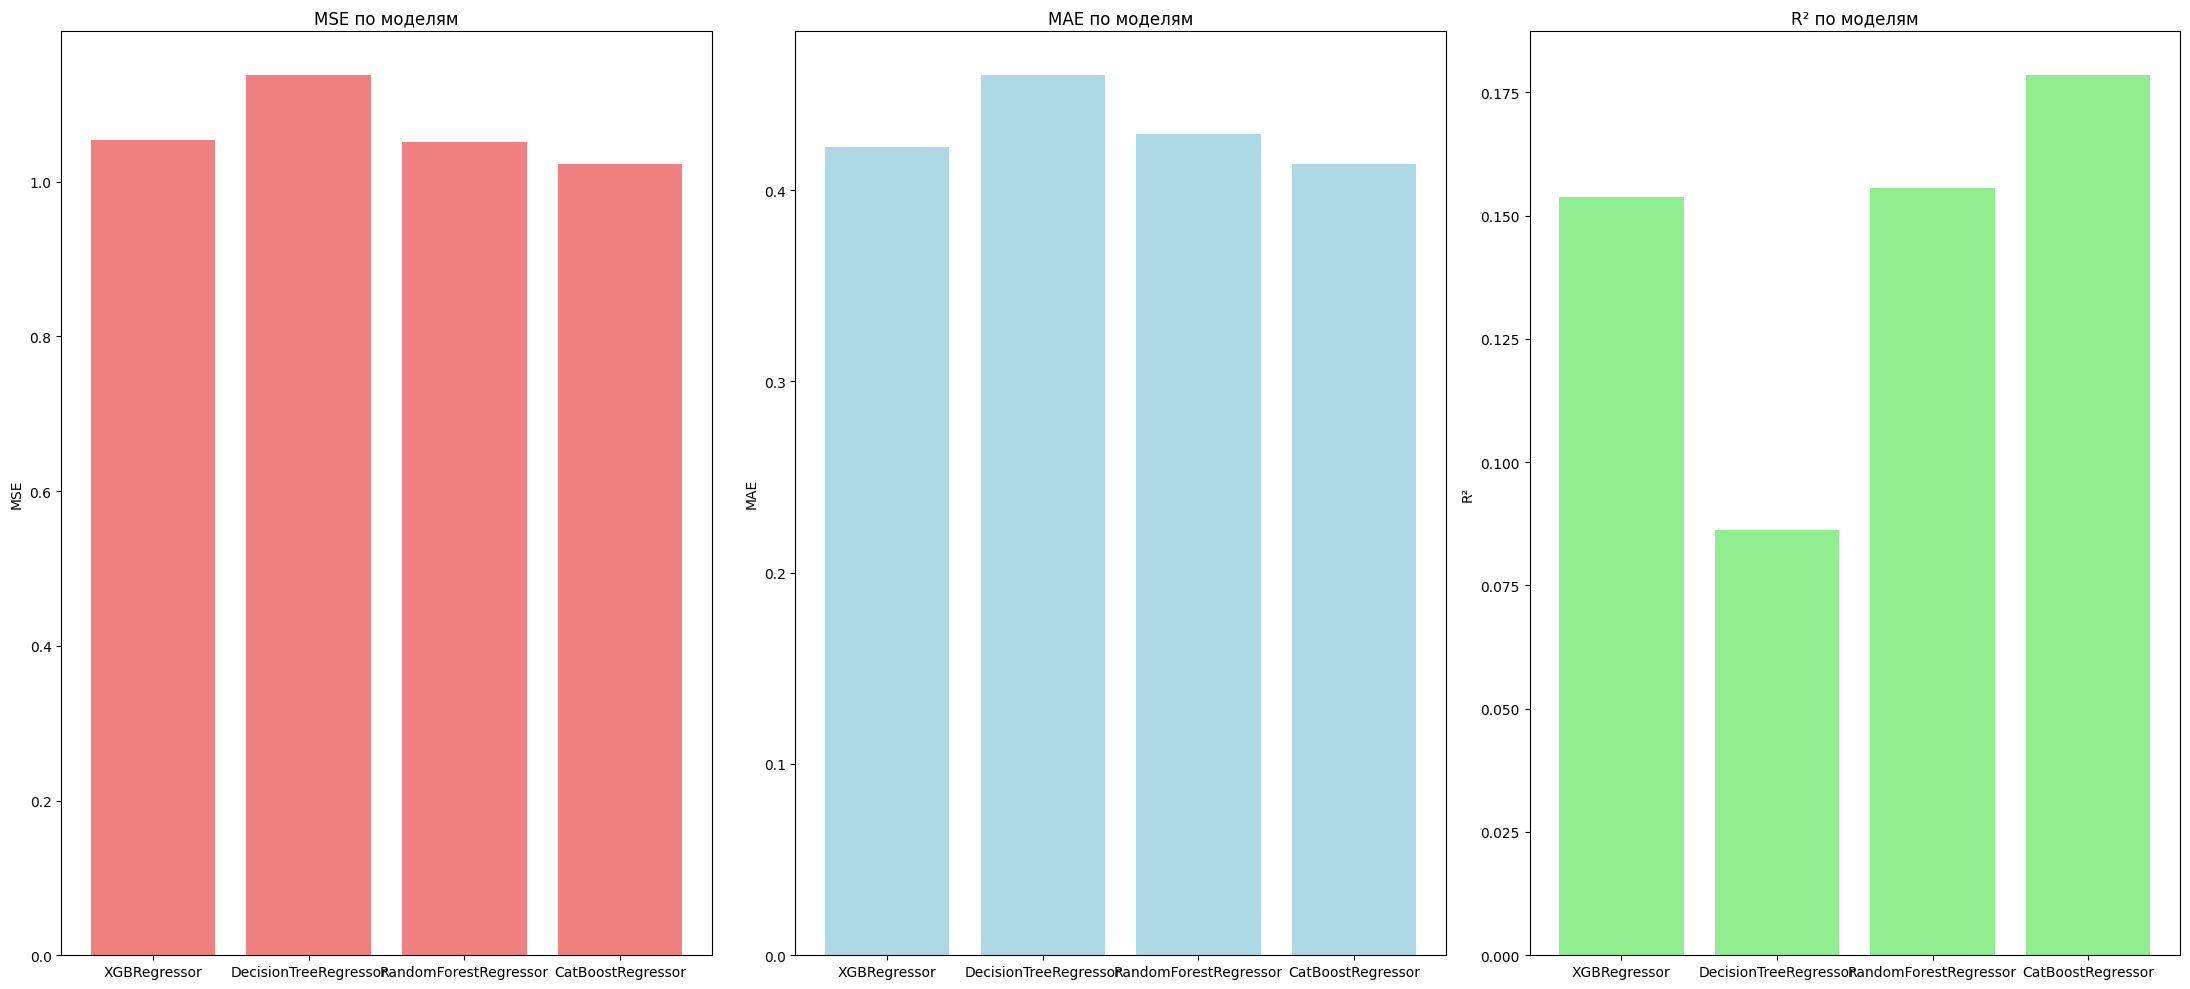

In [6]:
# Визуализация результатов
def plot_results(models_metrics):
    model_names = list(models_metrics.keys())
    mse_values = [metrics[0] for metrics in models_metrics.values()]
    mae_values = [metrics[1] for metrics in models_metrics.values()]
    r2_values = [metrics[2] for metrics in models_metrics.values()]

    plt.figure(figsize=(22, 10))

    plt.subplot(1, 3, 1)
    plt.bar(model_names, mse_values, color='lightcoral')
    plt.title('MSE по моделям')
    plt.ylabel('MSE')

    plt.subplot(1, 3, 2)
    plt.bar(model_names, mae_values, color='lightblue')
    plt.title('MAE по моделям')
    plt.ylabel('MAE')

    plt.subplot(1, 3, 3)
    plt.bar(model_names, r2_values, color='lightgreen')
    plt.title('R² по моделям')
    plt.ylabel('R²')

    plt.tight_layout()
    plt.show()

# Сохранение метрик для визуализации
metrics_dict = {name: (mse, mae, r2) for name, (mse, mae, r2) in zip(best_models.keys(), [(mean_squared_error(y_test, model_data['best_model'].predict(X_test)),
                       mean_absolute_error(y_test, model_data['best_model'].predict(X_test)),
                       r2_score(y_test, model_data['best_model'].predict(X_test)) ) for model_data in best_models.values()])}

plot_results(metrics_dict)

*На основе представленных результатов тестирования различных моделей регрессии можно сделать следующие выводы:*

- *Сравнительный анализ моделей*
- *XGBRegressor*
- MSE: 1.0531
- MAE: 0.4228
- R²: 0.1538
- Вывод: Модель показывает разумные результаты, но не является лучшей среди представленных.
- *DecisionTreeRegressor*
- MSE: 1.1373
- MAE: 0.4600
- R²: 0.0862
- Вывод: Производительность этой модели значительно ниже других. Высокие показатели MSE и MAE указывают на то, что дерево решений не смогло адекватно уловить зависимости в данных.
- *RandomForestRegressor*
- MSE: 1.0510
- MAE: 0.4291
- R²: 0.1555
- Вывод: Сравнимые результаты с XGBRegressor, но все же незначительно хуже. Показатели близки к лучшим результатам, но не являются самыми оптимальными.
- *CatBoostRegressor*
- MSE: 1.0225 (лучшее значение)
- MAE: 0.4134 (лучшее значение)
- R²: 0.1784 (лучшее значение)
- Вывод: Эта модель показала наилучшие результаты по всем метрикам, что свидетельствует о ее способности лучше всего подстраиваться под данные.
*Общий вывод*
- На основании тестовых показателей CatBoostRegressor продемонстрировал наилучшие результаты среди указанных моделей, особенно по метрике MSE, MAE и R². Данная модель, вероятно, лучше всего справилась с задачей регрессии в данном контексте. DecisionTreeRegressor оказался наихудшим выбором, что свидетельствует о слабой способности модели захватывать сложные зависимости в данных.

*Данный код демонстрирует процесс сохранения и загрузки обученных моделей машинного обучения с использованием библиотеки `pickle` в Python.*

In [7]:
import pickle

# Сохранение обученных моделей в pickle файл
for regressor_name, model_data in best_models.items():
    # Сохраняем с добавлением _SI
    filename = f"{regressor_name}_SI.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model_data['best_model'], file)
        print(f"Модель '{filename}' сохранена.")

# Пример загрузки модели из pickle файла
def load_model(regressor_name):
    # Загрузка с одним добавлением _SI
    filename = f"{regressor_name}_SI.pkl"
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

# Загрузка моделей для использования
loaded_xgb = load_model('XGBRegressor')
loaded_dt = load_model('DecisionTreeRegressor')
loaded_rf = load_model('RandomForestRegressor')
loaded_catboost = load_model('CatBoostRegressor')

# Проверка загруженной модели
y_test_pred = loaded_xgb.predict(X_test)
mse_loaded = mean_squared_error(y_test, y_test_pred)
r2_loaded = r2_score(y_test, y_test_pred)

Модель 'XGBRegressor_SI.pkl' сохранена.
Модель 'DecisionTreeRegressor_SI.pkl' сохранена.
Модель 'RandomForestRegressor_SI.pkl' сохранена.
Модель 'CatBoostRegressor_SI.pkl' сохранена.
